# Predicting and Completing Option Prices with a Black–Scholes Fully–Connected Network

## Nicholas Welsh
MTH 5320, Deep Learning

**Goal (snapshot t_0):** Given a few option quotes at one timestamp, complete an **arbitrage-free** surface of prices, Implied Volatility across strikes K and tenors T.  
**Method:** Fully-connected MLP → predicted IV 𝜎̂(K,T) → **Black–Scholes** price layer → fit to observed quotes.  


We will be building a black scholes model calculator in house and following this methodology:
 - Generate data using b-s model for pretraining
 - Utilize data from kaggle dataset for fine-tuning (see https://www.kaggle.com/datasets/kylegraupe/spy-daily-eod-options-quotes-2020-2022/)

## Data generation using the Black-Scholes model
Use Black-Scholes to generate "snapshots" of many quotes. Within each snapshot, pick 10-20 quotes as "observed", while treating the rest as targets for completion. This is fixed only once for fair comparison. We then use this phase to debug the model/tune rough ranges

Black Scholes Formula (Call):
$$ C = S\Phi(d_1)-Ke^{rT}\Phi(d_2) $$
Where:
- $C$: Price of the European call option
- $S$: Current price of the underlying asset (spot)
- $K$: Strike price of the option
- $r$: Risk-free interest rate
- $T$: Time to expiration (in years)
- $\sigma$: Volatility of the underlying asset's returns
- $\Phi(d_{1})$ and $\Phi(d_{2})$: The cumulative standard normal distribution function, which gives the probability that a variable will be less than a certain value

This function will need to be useful in data generation. It will be rebuilt inside the model itself for training.

"But wait! Why not make a function `bs_put_price` too?"
 - Answer: *They're not independent.* In fact, one can always be computed from the other using the **put-call parity** relationship:

 $$
C - P = S_{0}e^{qT} - Ke^{-rT}
$$
or rearranged for the put:
$$
P = C - S_{0}e^{qT} + Ke^{-rt}.
$$
That means, once our network learns the **call surface** (call prices for all strikes/maturities), we can immediately compute the corresponding put surface **analytically.**

In [1]:
# Global Imports
import torch
import matplotlib.pyplot as plt
import math
import platform
import json
import copy
import re
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import random
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from collections import defaultdict

We now implement a Black–Scholes pricer in Python to generate synthetic option prices and to keep training/evaluation in price units. This function maps inputs 
$(S0,K,T,r,q,\sigma)$ to closed-form call/put prices and will be reused across data generation and loss computation.

In [2]:
def bs_price(spot, strike, years, r, q, sigma, option="call"):
    T = np.asarray(years, dtype=float)
    S = np.asarray(spot, dtype=float)
    K = np.asarray(strike, dtype=float)
    sig = np.asarray(sigma, dtype=float)

    eps = 1e-12  # fix divide by zero error

    T = np.maximum(T, eps)
    sig = np.maximum(sig, 1e-12)

    d1 = (np.log(S / K) + (r - q + 0.5 * sig**2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)

    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)

    if option == "call":
        return S * np.exp(-q * T) * Nd1 - K * np.exp(-r * T) * Nd2
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


Splitting snapshots deterministically into train/val and creating an observed/holdout mask per snapshot can help us for the experiment. This mimics the “few observed quotes per day” scenario and lets us evaluate completion on held-out contracts.

In [3]:
def make_snapshot(snapshot_id, n_strikes=30, tenors_days=(7,14,30,60,90,180,365),
                  smile=False, rng=None):
    rng = np.random.default_rng(rng)

    S0 = rng.uniform(50, 500)
    r = rng.uniform(0.00, 0.05)
    q = rng.uniform(0.00, 0.03)

    m = rng.uniform(0.6, 1.4, size=n_strikes)
    K = np.sort(S0 * m)
    T = np.array(tenors_days) / 365.0

    K_grid, T_grid = np.meshgrid(K, T, indexing="xy")
    S_grid = np.full_like(K_grid, S0)
    r_grid = np.full_like(K_grid, r)
    q_grid = np.full_like(K_grid, q)

    # Volatility: constant or simple smile
    if not smile:
        sigma_snap = rng.uniform(0.10, 0.60)
        sigma_grid = np.full_like(K_grid, sigma_snap)
    else:
        ell = np.log(S0 / K_grid)
        a = rng.uniform(0.10, 0.50)
        b = rng.uniform(-0.20, 0.20)
        c = rng.uniform(0.00, 0.20)
        d = rng.uniform(-0.05, 0.10)
        sigma_grid = np.clip(a + b*ell + c*ell**2 + d*np.sqrt(T_grid), 0.05, 2.0)

    P_mid = bs_price(S_grid, K_grid, T_grid, r_grid, q_grid, sigma_grid, option="call")

    noise = rng.normal(loc=0.0, scale=0.01*np.maximum(0.1, P_mid))
    P_obs = np.clip(P_mid + noise, 0.0, None)

    df = pd.DataFrame({
        "snapshot_id": snapshot_id,
        "S0": S_grid.ravel(),
        "K": K_grid.ravel(),
        "T": T_grid.ravel(),
        "r": r_grid.ravel(),
        "q": q_grid.ravel(),
        "sigma_true": sigma_grid.ravel(),
        "price_mid": P_mid.ravel(),
        "price_obs": P_obs.ravel(),
    })
    return df


In [4]:
def make_dataset(n_snapshots=2000, smile=False, seed=42):
    rng = np.random.default_rng(seed)
    dfs = []
    for sid in range(n_snapshots):
        df = make_snapshot(sid, smile=smile, rng=rng)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [5]:
def split_snapshots(n_snapshots, train=0.8, val=0.1, seed=7):
    rng = np.random.default_rng(seed)
    ids = np.arange(n_snapshots)
    rng.shuffle(ids)
    n_train = int(train*n_snapshots)
    n_val = int(val*n_snapshots)
    return {
        "train": ids[:n_train],
        "val": ids[n_train:n_train+n_val],
        "test":  ids[n_train+n_val:]
    }

In [6]:
def make_observed_mask(df, observed_per_snapshot=15, seed=99):
    rng = np.random.default_rng(seed)
    mask = {}
    for sid, df_s in df.groupby("snapshot_id"):
        idx = df_s.index.values
        choose = min(observed_per_snapshot, len(idx))
        obs_idx = rng.choice(idx, size=choose, replace=False)
        mask[int(sid)] = np.sort(obs_idx)
    return mask

# Model Creation
Now that we have created the B-S Model and functions that will help us generate synthetic code, we can now work on the creation of the model itself. The architecture is as follows:
- Fully connected Multi-Layer Perceptron (MLP)
- Depth $\times$ width: 5 hidden layers $\times$ 256 units
- Activation: SiLU (Sigmoid Linear Unit)

The model has the following inputs:
- log-moneyness: $ln(S0/K)$
	- how far the strike is from the spot
- time to expiry: $\tau$ in years
- rates: risk-free $r$ and dividend yield $q$
- _(optional)_ scaled spot $S_{0} / 100$

The model would then output:
- Implied Volatility $\hat{\sigma}(K,T)>0$
  - We then plug $\hat{\sigma}$ into Black-Scholes to get a price $\hat{C}$.

In [7]:
# Dr white's implementation
# Device selection: CUDA -> MPS (Apple Silicon) -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device.type}\n")

if device.type == "cuda":
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} CUDA device(s):")
    for idx in range(num_gpus):
        print(f"  [{idx}] {torch.cuda.get_device_name(idx)}")
elif device.type == "mps":
    print("Apple Metal (MPS) device available")
else:
    print("Running on CPU")

print("\nPython:", platform.python_version(), "| PyTorch:", torch.__version__)

Using device: cuda

Found 1 CUDA device(s):
  [0] NVIDIA GeForce RTX 4070 SUPER

Python: 3.12.3 | PyTorch: 2.4.1


In [8]:
class MLP_IV(nn.Module):
    def __init__(self, in_dim=5, width=256, depth=5, eps=1e-4):
        super().__init__()
        layers = []
        dims = [in_dim] + [width]*depth
        self.backbone = nn.Sequential(
          nn.Linear(in_dim, width), nn.SiLU(),
          nn.Linear(width, width), nn.SiLU(),
          nn.Linear(width, width), nn.SiLU(),
          nn.Linear(width, width), nn.SiLU(),
          nn.Linear(width, width), nn.SiLU(),
        )
        self.head = nn.Linear(width, 1)
        self.softplus = nn.Softplus()
        self.eps = eps

    def forward(self, x):
        h = self.backbone(x)
        sigma = self.softplus(self.head(h)) + self.eps
        return sigma.squeeze(-1)


In [9]:
def normal_cdf(x):
    # Stable CDF via PyTorch's error function (keeps it differentiable)
    # Used in calculating the call price in Black-Scholes
    return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def bs_call_price(S, K, tau, r, q, sigma):
    # Implementation of Black-Scholes Call price in PyTorch
    S = torch.clamp(S, min=1e-12)
    K = torch.clamp(K, min=1e-12)
    tau = torch.clamp(tau, min=1e-12)
    sqrt_tau = torch.sqrt(tau)

    d1 = (torch.log(S/K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    Nd1 = normal_cdf(d1)
    Nd2 = normal_cdf(d2)
    disc_q = torch.exp(-q * tau)
    disc_r = torch.exp(-r * tau)
    C = S * disc_q * Nd1 - K * disc_r * Nd2
    return C


To ensure readability and ease-of-use for the results, we will be using Dataloaders. We wrap data into PyTorch datasets/dataloaders with deterministic shuffling and worker seeding. This ensures consistent minibatches across runs and clean separation of train vs. validation.

In [10]:
# Custom dataset for the MLP Model
class OptionDataset(Dataset):
    def __init__(self, df, stats=None, standardize=True):
        self.df = df.reset_index(drop=True)
        # features for the MLP
        log_mny = np.log(self.df["S0"].values / self.df["K"].values)
        T = self.df["T"].values
        r = self.df["r"].values
        q = self.df["q"].values
        S0_scaled = self.df["S0"].values / 100.0

        # fit stats on train; reuse them for val/test
        if stats is None:
            stats = {
              "T_mu": T.mean(), "T_sd": T.std() + 1e-8,
              "r_mu": r.mean(), "r_sd": r.std() + 1e-8,
              "q_mu": q.mean(), "q_sd": q.std() + 1e-8,
            }
        self.stats = stats

        if standardize:
            Tn = (T - stats["T_mu"]) / stats["T_sd"]
            rn = (r - stats["r_mu"]) / stats["r_sd"]
            qn = (q - stats["q_mu"]) / stats["q_sd"]
        else:
            Tn, rn, qn = T, r, q

        X = np.stack([log_mny, Tn, rn, qn, S0_scaled], axis=1).astype(np.float32)

        # store tensors
        self.X = torch.from_numpy(X)
        self.S0 = torch.from_numpy(self.df["S0"].values.astype(np.float32))
        self.K = torch.from_numpy(self.df["K"].values.astype(np.float32))
        self.T = torch.from_numpy(self.df["T"].values.astype(np.float32))   # raw for BS
        self.r = torch.from_numpy(self.df["r"].values.astype(np.float32))
        self.q = torch.from_numpy(self.df["q"].values.astype(np.float32))
        self.P = torch.from_numpy(self.df["price_obs"].values.astype(np.float32))
        self.sid = torch.from_numpy(self.df["snapshot_id"].values.astype(np.int64))

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        return {
            "features": self.X[i],
            "S0": self.S0[i], "K": self.K[i], "T": self.T[i],
            "r": self.r[i], "q": self.q[i],
            "P_obs": self.P[i],
            "sid": self.sid[i],
            "stats": self.stats,
        }


## Creating the Loss function
Due to the nature of the problem we are trying to solve, it would be naive to implement a single function to act as our Loss. Intuitively, we can approach this with a more modular mindset.
Instead of implementing one large Loss function $L$, we create three separate parts of a greater whole. The benefits of doing this include:
 - Debugging/monitoring each piece separately
 - Turning on/off certain loss functions during training
 - Allowing certain loss functions to be weighted differently

 If we just use a single formula, we can't tell whether the model is missing because it's not fitting the data or because a regularizer is too strong.

 We can proceed with the mental model:
1. A fit-to-market loss function `loss_fit_price`
	- It uses only the quotes observed (our 15 per snapshot)
	- It teaches the model to "Match the market at the points we actually saw."
	- This is the "Primary teacher"
2. No-arbitrage shape penalty `loss_noarb_bounds`
	- Uses the model's predicted prices at supervised points
	- It teaches the model to "stay inside basic bounds!"
		- $0\leq C \leq S_0 e^{-qT}$
	- These are soft constraints/regularizers, small weights. We don't want them to dominate.
3. Physics (PDE) Residual + Boundary/Terminal `loss_pde_and_bc`
	- It uses collocation points we label, autodiff to get $u_t,u_S,u_{SS}$ and check the Black-Scholes PDE and simple boundary/terminal conditions.
	- It teaches the model to "Be locally consistent with the BS dynamics, respecting the payoff at certain points".
	- Since it doesn't use labeled data, it should be a different kind of term
	- **Idea:** Start training without it **(warm-up)** and then turn it on with a small weight, so it regularizes rather than overpowers the fit.


Overall, the total loss is:

$$
L = L_{\text{fit}} + \lambda_{\text{arb}} \space L_{\text{arb}} + \lambda_{\text{pde}} \space L_{\text{pde}} + \lambda_{\text{bc}} \space L_{\text{bc}}
$$

$$
L_{\text{arb}} = \mathbb{E}(\text{ReLU}(0-C)^2 + \text{ReLU}(C-U)^2)
$$

For the PDE Loss function, just the PDE residual alone is not enough. Many surfaces can satisfy it locally. Therefore, we need three panlties to make the solution unique/physically sensible across the whole domain. These are:
1. Terminal Payoff $(\tau \approx 0)$
	- "Initial Condition" in time
    - Enforces the idea that the option is worth its payoff at expiry.
    - Without it, many different surfaces could satisfy the PDE locally, but disagree at expiry.
2. Zero-spot boundary (S = 0)
	- Left boundary in price space
    - Enforces "uselessness" to a call for any $\tau > 0$.
    - Prevents the network from inventing positive values when the call itself is worthless.
    - S -> 0
3. Large-S slope (Delta)
	- Right boundary in price space
    - Enforces the idea that, for large S, a call behaves like stock with divident yield q: $\frac{\partial u}{\partial S} \approx e^{-qT}$
    - Delta is required to prevent the prices to explode/dominate the loss when S is high.
    - S -> $\infty$

Also, we sample collocation points near batch inputs using a seeded generator for determinism. This provides off-data locations where PDE and boundary penalties guide the surface.

In [11]:
# Compute the supervised fit loss
def loss_fit_price(model, batch, mode="mae_rel"):

    # Pull the tensors from the batch
    X = batch["features"]
    S0 = batch["S0"]
    K = batch["K"]
    T = batch["T"]
    r = batch["r"]
    q = batch["q"]
    P = batch["P_obs"] # Observed call prices

    # Predict Implied Volatility based on the tensors
    sigma_hat = model(X)

    # Decode to price with the Black-Scholes model
    C_hat = bs_call_price(S0, K, T, r, q, sigma_hat)

    resid = (C_hat - P).abs()
    eps = 1e-8

    if mode == "mae":
        L_fit = resid.mean()

    elif mode == "mae_rel":
        # scale by a simple price scale so long-T, ATM doesn't dominate
        scale = S0 * torch.exp(-q*T) + eps
        L_fit = (resid / scale).mean()

    else:
        raise ValueError("mode must be one of {'mae','mae_rel'")

    return L_fit, {"sigma_hat": sigma_hat, "C_hat": C_hat}

# Penalize prices that violate the basic no-arbitrage bounds for European Calls
def loss_noarb_bounds(C_hat, S0, T, q):
    # Tiny epsilon to reduce noise
    epsilon = 1e-8
    
    # Compute the upper bound for every contract
    U = S0 * torch.exp(-q * T)

    # Measure violations (Upper/Lower), ReLU keeps penalty 0 when inside bounds
    lower_bound_violation = torch.relu((0.0 - epsilon) - C_hat)
    upper_bound_violation = torch.relu(C_hat - (U + epsilon))

    # Return a penalty scalar based on the bound violations
    return (upper_bound_violation.pow(2) + lower_bound_violation.pow(2)).mean()


# Create synthetic points where we don't have the market quotes
def sample_collocation(
    batch,
    n_colloc=None,
    s_factor=(0.4, 2.5),
    tau_skew=0.35,
    generator=None,         # NEW: torch.Generator for determinism
    device=None             # NEW: explicit device, optional
):
    """
    Draws collocation points deterministically when `generator` is provided.
    Uses the same normalization stats as training.
    """
    # --- setup ---
    device = device or batch["S0"].device
    if n_colloc is None:
        n_colloc = batch["S0"].shape[0]

    # choose the generator to use
    if generator is None:
        # fall back to global (non-deterministic), but in your runs pass GEN_CPU/GEN_CUDA
        generator = torch.Generator(device=device).manual_seed(0)

    N = batch["S0"].shape[0]

    # --- sample indices from the current batch (deterministic with generator) ---
    idx = torch.randint(0, N, (n_colloc,), device=device, generator=generator)

    # --- gather base tensors ---
    S0_ref = batch["S0"][idx]
    K      = batch["K"][idx]
    r      = batch["r"][idx]
    q      = batch["q"][idx]

    # tau in [0, T_max]
    T_max = torch.clamp(batch["T"].max(), min=1e-8)

    # Skewed tau: U^tau_skew with tau_skew<1 ⇒ more weight near 1 ⇒ larger tau
    U   = torch.rand(n_colloc, device=device, generator=generator)
    tau = T_max * U.pow(tau_skew)

    # S in [smin, smax] * S0_ref
    smin, smax = s_factor
    U_s = torch.rand(n_colloc, device=device, generator=generator)
    S   = S0_ref * (smin + (smax - smin) * U_s)

    # --- build normalized features with the SAME stats as training ---
    stats = batch["stats"]
    T_mu = torch.as_tensor(stats["T_mu"], device=device, dtype=torch.float32)
    T_sd = torch.as_tensor(stats["T_sd"], device=device, dtype=torch.float32)
    r_mu = torch.as_tensor(stats["r_mu"], device=device, dtype=torch.float32)
    r_sd = torch.as_tensor(stats["r_sd"], device=device, dtype=torch.float32)
    q_mu = torch.as_tensor(stats["q_mu"], device=device, dtype=torch.float32)
    q_sd = torch.as_tensor(stats["q_sd"], device=device, dtype=torch.float32)

    log_mny   = torch.log(S0_ref / K)
    tau_n     = (tau - T_mu) / T_sd
    r_n       = (r   - r_mu) / r_sd
    q_n       = (q   - q_mu) / q_sd
    S0_scaled = S0_ref / 100.0

    X_coll = torch.stack([log_mny, tau_n, r_n, q_n, S0_scaled], dim=-1)

    return {
        "S": S, "K": K, "tau": tau, "r": r, "q": q,
        "X_coll": X_coll, "stats": batch["stats"],
        "S0_ref": S0_ref
    }

    


def loss_pde_and_bc(model, coll, lambda_bc=1e-4):

    # Pull tensors from coll
    X_coll = coll["X_coll"]
    S = coll["S"].detach().clone().requires_grad_(True)
    tau = coll["tau"].detach().clone().requires_grad_(True)
    K = coll["K"]
    r = coll["r"]
    q = coll["q"]
    stats = coll["stats"]
    S0_ref = coll["S0_ref"]

    # Predict Implied Volatility at collocation points
    sigma_hat = model(X_coll)

    #Price surface at collocation points
    u = bs_call_price(S, K, tau, r, q, sigma_hat)

    # Take first derivative of u w.r.t S
    u_S = torch.autograd.grad(
        outputs = u, 
        inputs = S, 
        grad_outputs = torch.ones_like(u),
        create_graph = True
    )[0]

    # Take second derivative of u w.r.t S
    u_SS = torch.autograd.grad(
        outputs = u_S,
        inputs = S,
        grad_outputs = torch.ones_like(u_S),
        create_graph = True
    )[0]

    # Take time derivative of u w.r.t tau
    u_tau = torch.autograd.grad(
        outputs = u,
        inputs = tau,
        grad_outputs = torch.ones_like(u),
        create_graph = True
    )[0]

    # Form the Black-Scholes PDE residual
    R_PDE = u_tau + 0.5 * sigma_hat**2 * S.pow(2) * u_SS + (r - q) * S * u_S - (r * u)

    L_pde = torch.mean(R_PDE.pow(2))

    # terminal payoff - Rebuild input features with a small tau value (tau0 = 1e-6) to get a new Implied Volatility
    tau0 = torch.full_like(tau, 1e-6)
    
     # required: previous parameters from batch
    T_mu = torch.as_tensor(stats["T_mu"], device=device, dtype=torch.float32)
    T_sd = torch.as_tensor(stats["T_sd"], device=device, dtype=torch.float32)
    r_mu = torch.as_tensor(stats["r_mu"], device=device, dtype=torch.float32)
    r_sd = torch.as_tensor(stats["r_sd"], device=device, dtype=torch.float32)
    q_mu = torch.as_tensor(stats["q_mu"], device=device, dtype=torch.float32)
    q_sd = torch.as_tensor(stats["q_sd"], device=device, dtype=torch.float32)
    
    log_mny = torch.log(S0_ref / K)
    tau_n = (tau0 - T_mu) / T_sd
    r_n = (r - r_mu) / r_sd
    q_n = (q - q_mu) / q_sd
    S0_scaled = S0_ref / 100.0

    X_tau0 = torch.stack([log_mny, tau_n, r_n, q_n, S0_scaled], dim=-1)

    sigma_hat_tau0 = model(X_tau0)

    u_tau0 = bs_call_price(S, K, tau0, r, q, sigma_hat_tau0)
    payoff = torch.relu(S - K)
    L_term = F.mse_loss(u_tau0, payoff)

    # zero spot boundary (left boundary in price space)
    u_S0 = bs_call_price(torch.zeros_like(S), K, tau, r, q, sigma_hat)
    L_S0 = torch.mean(u_S0**2)

    # Large-S delta behavior (right boundary in price space)
    S_big = 2.5 * S0_ref
    S_big = S_big.detach().clone().requires_grad_(True)
    u_big = bs_call_price(S_big, K, tau, r, q, sigma_hat)
    u_S_big = torch.autograd.grad(
        outputs=u_big,
        inputs=S_big,
        grad_outputs=torch.ones_like(u_big),
        create_graph=False
    )[0]

    delta = torch.exp(-q * tau)

    L_delta = F.mse_loss(u_S_big, delta)

    # Combine all three terms
    L_bc = L_term + L_S0 + L_delta
    
    # return L_pde and L_bc * lambda_bc
    return L_pde, L_bc * lambda_bc
    



## Data training
1. Create Synthetic data using the B-S model / place in a dataloader for model to digest
2. Get model on one minibatch
3. Perform training loop


We set all random seeds (Python/NumPy/PyTorch) and force deterministic kernels where possible. This makes model training, collocation sampling, and data shuffling exactly reproducible for the paper’s results.

In [12]:
# -------------------- Reproducibility setup --------------------

SEED = 2025  # Choose the seed here (Report's seed: 2025)

def set_seed(seed: int = 42, deterministic: bool = True):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.use_deterministic_algorithms(True, warn_only=False)
        os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")
    else:
        torch.backends.cudnn.benchmark = True

    gen_cpu  = torch.Generator(device="cpu").manual_seed(seed)
    gen_cuda = torch.Generator(device=("cuda" if torch.cuda.is_available() else "cpu")).manual_seed(seed)
    return gen_cpu, gen_cuda

GEN_CPU, GEN_CUDA = set_seed(SEED, deterministic=True)

def worker_init_fn(worker_id: int):
    base = SEED
    np.random.seed(base + worker_id)
    random.seed(base + worker_id)
    torch.manual_seed(base + worker_id)


In [13]:
# MAKE SYNTHETIC DATA
df = make_dataset(n_snapshots=500, smile=True, seed=42)

splits   = split_snapshots(n_snapshots=df["snapshot_id"].nunique(), train=0.8, val=0.1, seed=7)
obs_mask = make_observed_mask(df, observed_per_snapshot=15, seed=99)

def filter_by_snapshots(df, ids):
    return df[df["snapshot_id"].isin(ids)].copy()

def observed_only(df_split, obs_mask):
    keep_idx = []
    for sid, g in df_split.groupby("snapshot_id"):
        idx_obs = obs_mask.get(int(sid), [])
        keep_idx.extend([i for i in idx_obs if i in g.index])
    return df_split.loc[keep_idx].reset_index(drop=True)

df_train = filter_by_snapshots(df, splits["train"])
df_val = filter_by_snapshots(df, splits["val"])

df_train_obs = observed_only(df_train, obs_mask)
df_val_obs = observed_only(df_val,   obs_mask)

NUM_WORKERS = 4  # 0 for absolute simplicity
BS = 1024

# DATASETS (fit stats on train, reuse on val)
train_ds = OptionDataset(df_train_obs, stats=None, standardize=True)
val_ds = OptionDataset(df_val_obs, stats=train_ds.stats, standardize=True)

# DATALOADERS
train_loader = DataLoader(
    train_ds, batch_size=BS, shuffle=True,
    generator=GEN_CPU, num_workers=NUM_WORKERS,
    worker_init_fn=worker_init_fn, persistent_workers=(NUM_WORKERS>0),
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=BS, shuffle=False,
    num_workers=NUM_WORKERS, worker_init_fn=worker_init_fn,
    persistent_workers=(NUM_WORKERS>0), pin_memory=True
)

# helper to move a batch to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(batch, device):
    return {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}


In [14]:
GEN_CPU, GEN_CUDA = set_seed(SEED, deterministic=True)

# MODEL + ADAM OPTIMIZER
model = MLP_IV().to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,            # good default
    betas=(0.9, 0.999), # standard Adam
    eps=1e-8,
    weight_decay=1e-5   # mild L2 on weights
)

We centralize experiment settings (hyperparameters, figure/ckpt paths) in a single config block. This removes “magic numbers” from code cells and makes runs easy to reproduce and tweak.

In [15]:
ckpt_path = "model_best.pt"
best_val  = float("inf")
patience  = 5
bad_epochs = 0
log_every = 1  # epochs

### Stage 1: Pretraining on Synthetic Data
We generate a large synthetic dataset under Black–Scholes as a pretraining prior. This covers sparse regions of 
$(\text{log}⁡(S0/K),T)$ and stabilizes subsequent fine-tuning on real snapshots.

In [16]:
# minimal training loop (includes warm-up, then physics)
EPOCHS = 20
lambda_arb = 1e-3
lambda_pde = 0.0     # warm-up off
lambda_bc  = 1e-4
pde_enabled = False

train_loader = DataLoader(
    train_ds, batch_size=BS, shuffle=True, generator=GEN_CPU,
    num_workers=NUM_WORKERS, worker_init_fn=worker_init_fn,
    persistent_workers=(NUM_WORKERS>0), pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BS, shuffle=False,
    num_workers=NUM_WORKERS, worker_init_fn=worker_init_fn,
    persistent_workers=(NUM_WORKERS>0), pin_memory=True
)

for epoch in range(EPOCHS):
    model.train()
    running = {"fit":0.0, "arb":0.0, "pde":0.0, "bc":0.0, "n":0}

    for batch in train_loader:
        batch = to_device(batch, device)

        # supervised fit
        L_fit, cache = loss_fit_price(model, batch, mode="mae_rel")

        # bounds (no arbitrage)
        L_arb = loss_noarb_bounds(cache["C_hat"], batch["S0"], batch["T"], batch["q"])
        

        # PDE + BC
        g_run = GEN_CUDA if (device.type == "cuda") else GEN_CPU

        coll = sample_collocation(
            batch,
            n_colloc=len(batch["S0"]),
            generator=g_run,     # <- deterministic source of randomness
            device=device
        )
        L_pde, L_bc = loss_pde_and_bc(model, coll, lambda_bc=lambda_bc)

        # warm-up first few epochs: turn on PDE after, say, 5 epochs
        if epoch == 5 and not pde_enabled:
            lambda_pde = 1e-4
            pde_enabled = True
            bad_epochs = 0          # reset the early-stop timer
            for g in optimizer.param_groups: g["lr"] = 2e-4
            print(f"pde is on at epoch {epoch+1}")


        loss = (
            L_fit
            + lambda_arb * L_arb
            + lambda_pde * L_pde
            + L_bc
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        bs = batch["S0"].shape[0]
        running["fit"] += L_fit.item()*bs
        running["arb"] += L_arb.item()*bs
        running["pde"] += L_pde.item()*bs
        running["bc"] += (L_bc.item())*bs
        running["n"] += bs

    pde_raw = running['pde']/running['n'] # unweighted L_pde avg
    pde_w = lambda_pde * pde_raw
    bc_w = running['bc']/running['n'] # already weighted inside loss_pde_and_bc

    print(f"Epoch {epoch+1:02d} | "
          f"fit {running['fit']/running['n']:.5f} | "
          f"arb {running['arb']/running['n']:.5f} | "
          f"pde_raw {pde_raw:.2e} | pde_w {pde_w:.2e} | bc_w {bc_w:.2e}")

    # Model validation
    model.eval()
    with torch.no_grad():
        val_fit_sum, val_n = 0.0, 0
        for batch in val_loader:
            batch = to_device(batch, device)
            L_fit, _ = loss_fit_price(model, batch, mode="mae_rel")
            bs = batch["S0"].shape[0]
            val_fit_sum += L_fit.item()*bs
            val_n += bs
    # early-stopping on validation fit (lower is better)
    val_fit = val_fit_sum / max(1, val_n)

    if val_fit < best_val - 1e-6:   # small margin to avoid flicker
        best_val = val_fit
        bad_epochs = 0
        torch.save({
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "stats": train_ds.stats,
            "lambda": {"arb": lambda_arb, "pde": lambda_pde, "bc": lambda_bc},
            "seed": SEED,
            "rng_state": {
                "python": random.getstate(),
                "numpy": np.random.get_state(),
                "torch_cpu": torch.random.get_rng_state(),
                "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
            },
        }, ckpt_path)
        print("(best so far, checkpoint saved)")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1} (no val improvement for {patience} epochs).")
            break

    # (optional) log raw physics terms once in a while
    if (epoch+1) % log_every == 0:
        print(f"          λ_pde={lambda_pde:.1e}")



Epoch 01 | fit 0.04191 | arb 0.00000 | pde_raw 5.42e+03 | pde_w 0.00e+00 | bc_w 1.96e-07
(best so far, checkpoint saved)
          λ_pde=0.0e+00
Epoch 02 | fit 0.02975 | arb 0.00000 | pde_raw 3.33e+03 | pde_w 0.00e+00 | bc_w 1.09e-07
(best so far, checkpoint saved)
          λ_pde=0.0e+00
Epoch 03 | fit 0.01474 | arb 0.00000 | pde_raw 8.93e+02 | pde_w 0.00e+00 | bc_w 1.84e-08
(best so far, checkpoint saved)
          λ_pde=0.0e+00
Epoch 04 | fit 0.01493 | arb 0.00000 | pde_raw 2.05e+02 | pde_w 0.00e+00 | bc_w 7.76e-10
          λ_pde=0.0e+00
Epoch 05 | fit 0.01492 | arb 0.00000 | pde_raw 2.00e+02 | pde_w 0.00e+00 | bc_w 4.89e-10
(best so far, checkpoint saved)
          λ_pde=0.0e+00
pde is on at epoch 6
Epoch 06 | fit 0.01429 | arb 0.00000 | pde_raw 2.24e+02 | pde_w 2.24e-02 | bc_w 5.95e-10
          λ_pde=1.0e-04
Epoch 07 | fit 0.01708 | arb 0.00000 | pde_raw 1.41e+02 | pde_w 1.41e-02 | bc_w 3.48e-11
          λ_pde=1.0e-04
Epoch 08 | fit 0.01863 | arb 0.00000 | pde_raw 1.23e+02 | pd

## What's next?
1. Add Early stopping / checkpoint
   - Track val L_fit for each epoch.
   - Keep the best so far and save `state_dict` + train stats when it improves
   - If no improvement for ~5 epochs then stop
3. Build tiny inference helper per snapshot
4. Visuals!

In [17]:
# save
torch.save(model.state_dict(), "model_best_weights.pt")
with open("train_stats.json", "w") as f:
    json.dump(train_ds.stats, f)

# load
state_dict = torch.load("model_best_weights.pt", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
with open("train_stats.json") as f:
    stats_best = json.load(f)


In [18]:
def infer_snapshot(model, df_s, stats, device):
    model.eval()
    with torch.no_grad():
        # 1) convert columns to tensors on the right device
        S0 = torch.as_tensor(df_s["S0"].values, dtype=torch.float32, device=device)
        K  = torch.as_tensor(df_s["K"].values,  dtype=torch.float32, device=device)
        T  = torch.as_tensor(df_s["T"].values,  dtype=torch.float32, device=device)
        r  = torch.as_tensor(df_s["r"].values,  dtype=torch.float32, device=device)
        q  = torch.as_tensor(df_s["q"].values,  dtype=torch.float32, device=device)

        # 2) features in torch (vectorized)
        log_mny   = torch.log(S0 / K)
        S0_scaled = S0 / 100.0

        # 3) stats on same device
        T_mu = torch.as_tensor(stats["T_mu"], dtype=torch.float32, device=device)
        T_sd = torch.as_tensor(stats["T_sd"], dtype=torch.float32, device=device)
        r_mu = torch.as_tensor(stats["r_mu"], dtype=torch.float32, device=device)
        r_sd = torch.as_tensor(stats["r_sd"], dtype=torch.float32, device=device)
        q_mu = torch.as_tensor(stats["q_mu"], dtype=torch.float32, device=device)
        q_sd = torch.as_tensor(stats["q_sd"], dtype=torch.float32, device=device)

        X = torch.stack([
            log_mny,
            (T - T_mu)/T_sd,
            (r - r_mu)/r_sd,
            (q - q_mu)/q_sd,
            S0_scaled
        ], dim=-1)

        sigma_hat = model(X).clamp_min(1e-8)
        C_hat = bs_call_price(S0, K, T, r, q, sigma_hat)
        return {"sigma_hat": sigma_hat, "C_hat": C_hat}


In [19]:
def price_mae(pred, true):
    return (pred - true).abs().mean().item()

def price_mape(pred, true, eps=1e-8):
    return ( (pred - true).abs() / (true.abs() + eps) ).mean().item()

def count_bounds_violations(C, S0, T, q, eps=1e-8):
    U = S0 * torch.exp(-q*T)
    lo = (C < -eps).sum().item()
    hi = (C > U + eps).sum().item()
    return lo, hi

In [20]:
# choose one test snapshot (take the first for convenience)
sid = sorted(df[df["snapshot_id"].isin(splits["test"])][ "snapshot_id" ].unique())[0]
df_s = df[df["snapshot_id"] == sid].copy()

# predict on ALL rows of this snapshot
out = infer_snapshot(model, df_s, stats_best, device)
C_hat = out["C_hat"]  # tensor on device


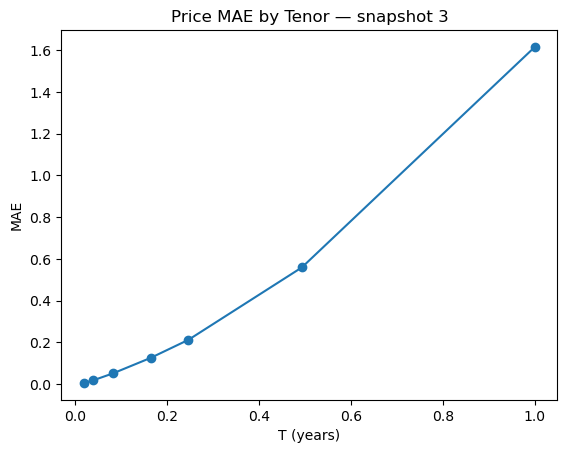

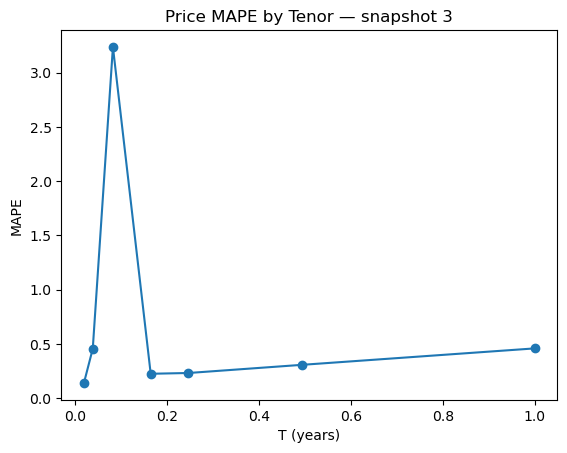

In [21]:
# NEW

T_vals = np.sort(df_s["T"].unique())
mae_T, mape_T = [], []

C_pred_np = C_hat.detach().cpu().numpy()
C_true_np = df_s["price_mid"].to_numpy()
T_np      = df_s["T"].to_numpy()

for T0 in T_vals:
    m = (np.abs(T_np - T0) < 1e-10)   # exact match on your synthetic grid
    if m.sum() == 0: 
        mae_T.append(np.nan); mape_T.append(np.nan); continue
    err  = np.abs(C_pred_np[m] - C_true_np[m])
    mae_T.append(err.mean())
    mape_T.append((err / (np.abs(C_true_np[m]) + 1e-8)).mean())

plt.figure()
plt.plot(T_vals, mae_T, marker='o')
plt.xlabel("T (years)"); plt.ylabel("MAE")
plt.title(f"Price MAE by Tenor — snapshot {sid}")
plt.show()

plt.figure()
plt.plot(T_vals, mape_T, marker='o')
plt.xlabel("T (years)"); plt.ylabel("MAPE")
plt.title(f"Price MAPE by Tenor — snapshot {sid}")
plt.show()

In [22]:
def build_grids_for_snapshot(df_s, C_hat_tensor):
    S0_np  = df_s["S0"].to_numpy()
    K_np   = df_s["K"].to_numpy()
    T_np   = df_s["T"].to_numpy()
    C_true = df_s["price_mid"].to_numpy()   # synthetic mid-prices
    C_pred = C_hat_tensor.detach().cpu().numpy()

    ell = np.log(S0_np / K_np)              # log-moneyness
    # round a bit so floats align on a grid
    ell_r = np.round(ell, 8)
    T_r   = np.round(T_np, 8)

    e_vals, e_idx = np.unique(ell_r, return_inverse=True)
    t_vals, t_idx = np.unique(T_r,   return_inverse=True)

    H, W = len(t_vals), len(e_vals)
    grid_true = np.full((H, W), np.nan)
    grid_pred = np.full((H, W), np.nan)
    grid_err  = np.full((H, W), np.nan)

    grid_true[t_idx, e_idx] = C_true
    grid_pred[t_idx, e_idx] = C_pred
    grid_err[t_idx, e_idx]  = np.abs(C_pred - C_true)

    return e_vals, t_vals, grid_true, grid_pred, grid_err

e_vals, t_vals, grid_true, grid_pred, grid_err = build_grids_for_snapshot(df_s, C_hat)


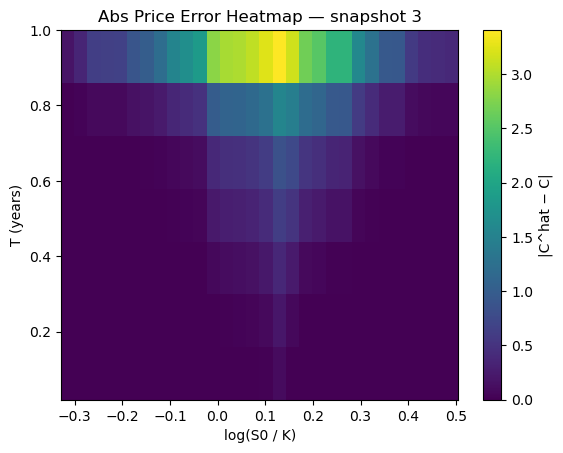

In [23]:
plt.figure()
extent = [e_vals.min(), e_vals.max(), t_vals.min(), t_vals.max()]
plt.imshow(grid_err, origin="lower", aspect="auto", extent=extent)
plt.xlabel("log(S0 / K)")
plt.ylabel("T (years)")
plt.title(f"Abs Price Error Heatmap — snapshot {sid}")
plt.colorbar(label="|C^hat − C|")
plt.show()


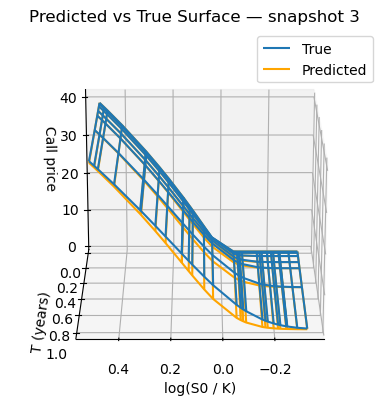

In [24]:
E, TT = np.meshgrid(e_vals, t_vals)  # same shape as grids

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# True surface (wireframe)
ax.plot_wireframe(E, TT, grid_true, label="True")

# Predicted surface (wireframe)
ax.plot_wireframe(E, TT, grid_pred, color="orange", label="Predicted" )

ax.set_xlabel("log(S0 / K)")
ax.set_ylabel("T (years)")
ax.set_zlabel("Call price")
ax.set_title(f"Predicted vs True Surface — snapshot {sid}")
ax.view_init(elev=20, azim=90)
plt.legend()
plt.show()


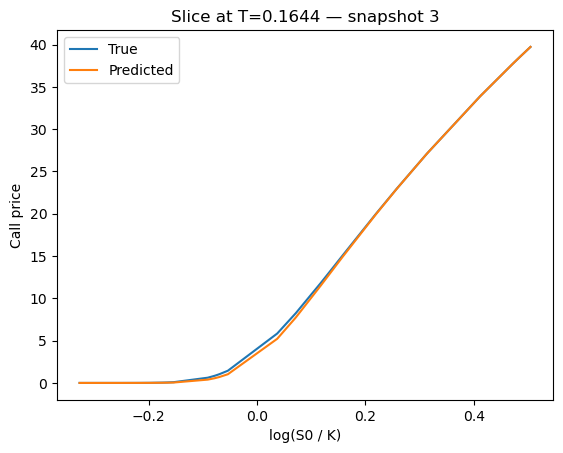

In [25]:
# pick the middle tenor row for a clean slice
row = len(t_vals) // 2
plt.figure()
plt.plot(e_vals, grid_true[row], label="True")
plt.plot(e_vals, grid_pred[row], label="Predicted")
plt.xlabel("log(S0 / K)")
plt.ylabel("Call price")
plt.title(f"Slice at T={t_vals[row]:.4f} — snapshot {sid}")
plt.legend()
plt.show()

## REAL DATA

As stated before, we will be using the kaggle dataset "$SPY Option Chains - Q1 2020 - Q4 2022". Below is the implementation of it.

The biggest hurdle was missing data, which will be talked about shortly

In [26]:
# DATA
csv_path = "spy_2020_2022.csv"
df_raw = pd.read_csv(csv_path, low_memory=False)

#strip spaces/brackets from column names: " [C_BID]" -> "C_BID"
clean = {c: c.strip().strip("[]").strip() for c in df_raw.columns}
df_raw = df_raw.rename(columns=clean)

df_raw.columns[:20].tolist()


['QUOTE_UNIXTIME',
 'QUOTE_READTIME',
 'QUOTE_DATE',
 'QUOTE_TIME_HOURS',
 'UNDERLYING_LAST',
 'EXPIRE_DATE',
 'EXPIRE_UNIX',
 'DTE',
 'C_DELTA',
 'C_GAMMA',
 'C_VEGA',
 'C_THETA',
 'C_RHO',
 'C_IV',
 'C_VOLUME',
 'C_LAST',
 'C_SIZE',
 'C_BID',
 'C_ASK',
 'STRIKE']

In [27]:
df_raw["QUOTE_DATE"]  = pd.to_datetime(df_raw["QUOTE_DATE"])
df_raw["EXPIRE_DATE"] = pd.to_datetime(df_raw["EXPIRE_DATE"])

for col in ["UNDERLYING_LAST","STRIKE","C_BID","C_ASK","C_LAST","DTE"]:
    if col in df_raw:
        df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

# Mid call price (fallback to last if bid/ask missing)
bid = df_raw["C_BID"]
ask = df_raw["C_ASK"]
last= df_raw["C_LAST"]
mid = 0.5*(bid+ask)
use_mid = (bid>0) & (ask>0)
price = np.where(use_mid, mid, last)

# Time to expiry in years (prefer DTE if present)
if "DTE" in df_raw:
    T_years = df_raw["DTE"] / 365.0
else:
    T_years = (df_raw["EXPIRE_DATE"] - df_raw["QUOTE_DATE"]).dt.days / 365.0

df = pd.DataFrame({
    "date": df_raw["QUOTE_DATE"],
    "S0": df_raw["UNDERLYING_LAST"],
    "K": df_raw["STRIKE"],
    "T": T_years,
    "price_mid": price,
})

# basic cleaning
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=["S0","K","T","price_mid"])
df = df[(df["S0"]>0) & (df["K"]>0) & (df["T"]>0) & (df["price_mid"]>0.01)]
# (optional) cap very long expiries if present
df = df[df["T"] <= 2.0]


In [28]:
# Add snapshot since this is what the dataset expects

# one snapshot per trading day
dates = pd.Index(sorted(df["date"].unique()))
date_to_sid = {d:i for i,d in enumerate(dates)}
df["snapshot_id"] = df["date"].map(date_to_sid).astype(int)

df["r"] = 0.0   # can upgrade later
df["q"] = 0.0   # can upgrade later

# supervised target (same as the synthetic pipeline)
df["price_obs"] = df["price_mid"]

# keep only the columns the pipeline uses
df = df[["snapshot_id","S0","K","T","r","q","price_mid","price_obs"]].reset_index(drop=True)
print("# snapshots:", df["snapshot_id"].nunique(), "| rows:", len(df))
df.head()


# snapshots: 758 | rows: 3259587


,snapshot_id,S0,K,T,r,q,price_mid,price_obs
0,417,451.85,255.0,0.005479,0.0,0.0,196.765,196.765
1,417,451.85,260.0,0.005479,0.0,0.0,191.770,191.770
2,417,451.85,265.0,0.005479,0.0,0.0,186.775,186.775
3,417,451.85,270.0,0.005479,0.0,0.0,181.775,181.775
4,417,451.85,275.0,0.005479,0.0,0.0,176.780,176.780


In [29]:
# split by snapshot

n_snaps = df["snapshot_id"].nunique()
splits  = split_snapshots(n_snaps, train=0.8, val=0.1, seed=7)
obs_mask = make_observed_mask(df, observed_per_snapshot=15, seed=99)

def filter_by_snapshots(d, ids):
    return d[d["snapshot_id"].isin(ids)].copy()

keep_train = np.concatenate([obs_mask[sid] for sid in splits["train"] if sid in obs_mask]) if len(splits["train"]) else []
keep_val   = np.concatenate([obs_mask[sid] for sid in splits["val"]   if sid in obs_mask]) if len(splits["val"])   else []

df_train_obs = df.loc[keep_train].copy()
df_val_obs   = df.loc[keep_val].copy()
df_test_all  = filter_by_snapshots(df, splits["test"])


In [30]:
train_ds = OptionDataset(df_train_obs, stats=None, standardize=True)
val_ds   = OptionDataset(df_val_obs,   stats=train_ds.stats, standardize=True)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=2048, shuffle=False, drop_last=False)


### Stage 2: Snapshot fine tuning on real data

We fine-tune per snapshot on a small observed subset and evaluate on the held-out contracts from the same day. This tests the model’s ability to complete a dense, plausible surface from few quotes.

In [31]:
# --- NEW: helpers for schedules ---
def pde_weight_schedule(epoch, on=10, ramp=8, max_w=1e-4, off_anneal=4, total_epochs=40):
    """
    λ_pde = 0 before 'on'; linearly ramps to max_w over 'ramp' epochs;
    in the last 'off_anneal' epochs, anneal down (keeps structure but lets MAE recover).
    """
    e = epoch  # 0-based
    if e < on:
        return 0.0
    # ramp up
    if e < on + ramp:
        frac = (e - on + 1) / float(ramp)
        return max_w * max(1e-2, min(1.0, frac))   # start tiny (~1e-2 * max_w)
    # steady phase
    if e < total_epochs - off_anneal:
        return max_w
    # anneal down near the end
    left = total_epochs - e
    frac = max(0.2, min(1.0, left / float(off_anneal)))  # don't go below 0.2*max_w
    return max_w * frac

def set_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g["lr"] = lr

In [32]:


GEN_CPU, GEN_CUDA = set_seed(SEED, deterministic=True)

#make new model, loading with the model_best_weights.pt from before
model = MLP_IV(in_dim=5, width=256, depth=5).to(device)
state = torch.load("model_best_weights.pt", map_location=device, weights_only=True)
model.load_state_dict(state)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
ckpt_path = "model_spy.pt"
best_val = float('inf'); bad_epochs = 0

Epoch 01 | fit 0.01286 | val_rel 0.01294 | val $MAE 4.8011 | SMAPE 79.13% | pde_raw 4.97e-01 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 02 | fit 0.00986 | val_rel 0.00667 | val $MAE 2.4899 | SMAPE 32.22% | pde_raw 1.48e+01 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 03 | fit 0.00609 | val_rel 0.00599 | val $MAE 2.2149 | SMAPE 36.71% | pde_raw 1.36e+02 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 04 | fit 0.00576 | val_rel 0.00591 | val $MAE 2.1919 | SMAPE 29.18% | pde_raw 1.26e+02 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 05 | fit 0.00557 | val_rel 0.00548 | val $MAE 2.0230 | SMAPE 28.79% | pde_raw 8.13e+01 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 06 | fit 0.00540 | val_rel 0.00538 | val $MAE 1.9846 | SMAPE 29.53% | pde_raw 1.24e+02 | λ_pde 0.00e+00 | pde_w~ 0.00e+00
(best so far, checkpoint saved)
Epoch 07 | fit 0.00537 | val_rel 0.00551

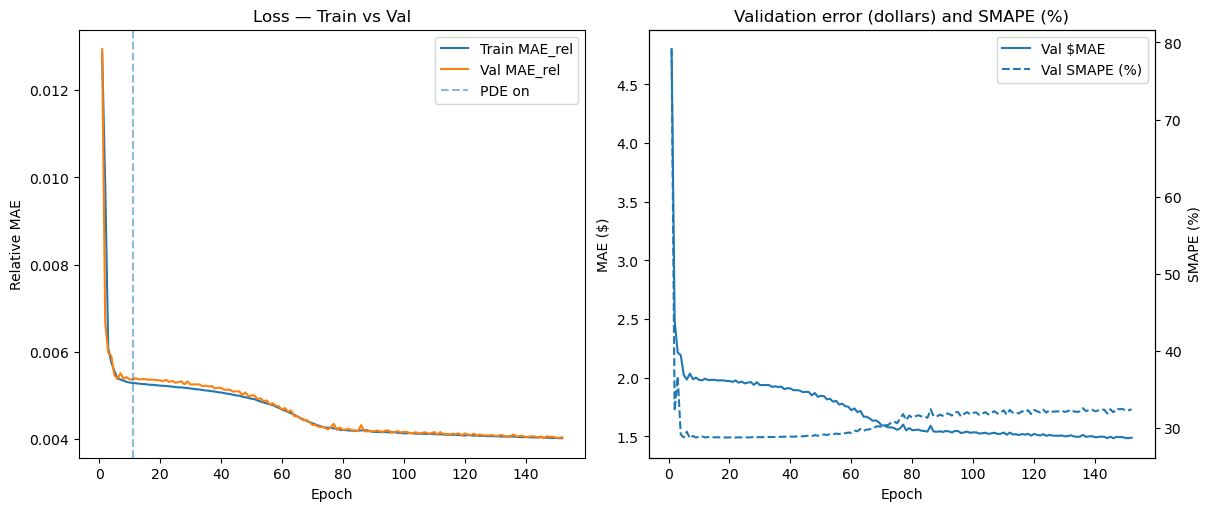

In [33]:
history = defaultdict(list)

# minimal training loop (includes warm-up, then physics)
base_lr      = 1e-4
patience     = 8
EPOCHS       = 200
lambda_arb   = 5e-4
lambda_bc    = 1e-4
lambda_pde_max = 1e-4
pde_on_epoch = 10 # 0-based index; PDE starts affecting loss at epoch 11 in your plot
pde_ramp_len = 8
pde_off_anneal = 4
es_grace_after_pde = 10   # do not count bad epochs for this many epochs after PDE starts
grad_clip = 1.0

# Reset best_val, bad epochs, etc
ckpt_path = "model_spy.pt"
patience   = 8
best_val  = float("inf")
bad_epochs = 0
history = defaultdict(list)
pde_enabled = False
pde_epoch_on = None

# --- NEW: state for EMA normalization of PDE residual (optional, very safe) ---
pde_ema = 0.0
ema_beta = 0.99

for epoch in range(EPOCHS):
    model.train()
    running = {"fit":0.0, "arb":0.0, "pde":0.0, "bc":0.0, "n":0}

    # --- schedule PDE weight for this epoch ---
    lambda_pde = pde_weight_schedule(epoch, on=pde_on_epoch, ramp=pde_ramp_len,
                                     max_w=lambda_pde_max, off_anneal=pde_off_anneal,
                                     total_epochs=EPOCHS)

    # detect first activation to apply LR cut & reset Adam moments
    if (not pde_enabled) and (lambda_pde > 0.0):
        pde_enabled = True
        pde_epoch_on = epoch + 1  # for plotting (1-based)
        # LOWER LR at the switch and reset optimizer moments
        optimizer = torch.optim.Adam(model.parameters(), lr=base_lr * 0.2, weight_decay=1e-5)
        print(f"[info] PDE enabled at epoch {epoch+1}; λ_pde={lambda_pde:.2e}; LR → {base_lr*0.2:.1e}")

    for batch in train_loader:
        batch = to_device(batch, device)

        # 1) supervised fit
        L_fit, cache = loss_fit_price(model, batch, mode="mae_rel")

        # 2) bounds (no arbitrage)
        L_arb = loss_noarb_bounds(cache["C_hat"], batch["S0"], batch["T"], batch["q"])

        # 3) PDE + BC (collocation)
        coll = sample_collocation(batch, n_colloc=len(batch["S0"]))
        L_pde_raw, L_bc = loss_pde_and_bc(model, coll, lambda_bc=lambda_bc)

        # normalize PDE by EMA of its raw magnitude to stabilize scale
        pde_ema = ema_beta * pde_ema + (1.0 - ema_beta) * float(L_pde_raw.detach().cpu())
        L_pde = L_pde_raw / (pde_ema + 1e-8)

        loss = L_fit + lambda_arb*L_arb + lambda_pde*L_pde + L_bc
        optimizer.zero_grad()
        loss.backward()

        # gradient clipping when PDE is active
        if pde_enabled:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        # logging
        bs = batch["S0"].shape[0]
        running["fit"] += L_fit.item()*bs
        running["arb"] += L_arb.item()*bs
        running["pde"] += L_pde_raw.item()*bs   # log raw for intuition
        running["bc"] += L_bc.item()*bs
        running["n"] += bs

    # ---- epoch aggregates (train) ----
    train_fit = running['fit']/running['n']
    pde_raw = running['pde']/running['n']
    pde_w = lambda_pde * (pde_raw / (pde_ema + 1e-8)) if pde_enabled else 0.0
    bc_w = running['bc']/running['n']

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_fit_sum = val_err_sum = val_smape_sum = 0.0
        val_n = 0
        for batch in val_loader:
            batch = to_device(batch, device)
            L_fit, cache = loss_fit_price(model, batch, mode="mae_rel")
            bs = batch["S0"].shape[0]
            val_fit_sum += L_fit.item()*bs
            err = (cache["C_hat"] - batch["P_obs"]).abs()
            val_err_sum   += err.sum().item()
            val_smape_sum += (2.0*err/(cache["C_hat"].abs()+batch["P_obs"].abs()+1e-8)).sum().item()
            val_n += bs

    val_fit = val_fit_sum / max(1, val_n)
    val_mae = val_err_sum / max(1, val_n)
    val_smape_pct = 100.0 * val_smape_sum / max(1, val_n)

    # --- log to history ---
    history["train_fit_rel"].append(train_fit)
    history["val_fit_rel"].append(val_fit)
    history["val_mae_abs"].append(val_mae)
    history["val_smape_pct"].append(val_smape_pct)
    history["pde_w"].append(pde_w)
    history["bc_w"].append(bc_w)

    print(f"Epoch {epoch+1:02d} | "
          f"fit {train_fit:.5f} | val_rel {val_fit:.5f} | "
          f"val $MAE {val_mae:.4f} | SMAPE {val_smape_pct:.2f}% | "
          f"pde_raw {pde_raw:.2e} | λ_pde {lambda_pde:.2e} | pde_w~ {pde_w:.2e}")

    # --- early stopping with GRACE after PDE turns on ---
    improved = val_fit < best_val - 1e-6
    if improved:
        best_val = val_fit
        bad_epochs = 0
        torch.save({
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "stats": train_ds.stats,
            "lambda": {"arb": lambda_arb, "pde": lambda_pde, "bc": lambda_bc},
            "seed": SEED,
            "rng_state": {
                "python": random.getstate(),
                "numpy": np.random.get_state(),
                "torch_cpu": torch.random.get_rng_state(),
                "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
            },
        }, ckpt_path)
        print("(best so far, checkpoint saved)")
    else:
        # during grace window after PDE switch, do not count bad epochs
        in_grace = (pde_epoch_on is not None) and ((epoch+1) - pde_epoch_on < es_grace_after_pde)
        if not in_grace:
            bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val improvement for {patience} epochs outside grace).")
            break



# Plot
epochs = np.arange(1, len(history["train_fit_rel"])+1)

# Side-by-side panels
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

# --- (A) Loss curves (left) ---
axL = axes[0]
axL.plot(epochs, history["train_fit_rel"], label="Train MAE_rel")
axL.plot(epochs, history["val_fit_rel"],   label="Val MAE_rel")
if pde_epoch_on is not None:
    axL.axvline(pde_epoch_on, ls="--", alpha=0.5, label="PDE on")
axL.set_ylabel("Relative MAE")
axL.set_xlabel("Epoch")
axL.set_title("Loss — Train vs Val")
axL.legend()

# --- (B) Dollar MAE + SMAPE (right) ---
axR  = axes[1]
axR2 = axR.twinx()  # secondary axis for SMAPE

l1 = axR.plot(epochs, history["val_mae_abs"], label="Val $MAE")
l2 = axR2.plot(epochs, history["val_smape_pct"], ls="--", label="Val SMAPE (%)")

axR.set_ylabel("MAE ($)")
axR2.set_ylabel("SMAPE (%)")
axR.set_xlabel("Epoch")
axR.set_title("Validation error (dollars) and SMAPE (%)")

# one combined legend on the right plot
lines  = l1 + l2
labels = [ln.get_label() for ln in lines]
axR.legend(lines, labels, loc="best")
plt.savefig("my_plot4.pdf", bbox_inches='tight')
plt.show()




In [34]:
# Now, "Given a few quotes at one moment, fill in the rest."
def pack_batch_from_df(df, stats, device):
    # tensors
    S0 = torch.as_tensor(df["S0"].values, dtype=torch.float32, device=device)
    K  = torch.as_tensor(df["K"].values,  dtype=torch.float32, device=device)
    T  = torch.as_tensor(df["T"].values,  dtype=torch.float32, device=device)
    r  = torch.as_tensor(df["r"].values,  dtype=torch.float32, device=device)
    q  = torch.as_tensor(df["q"].values,  dtype=torch.float32, device=device)
    P  = torch.as_tensor(df["price_mid"].values, dtype=torch.float32, device=device)

    # SAME normalization as training
    T_mu = torch.tensor(stats["T_mu"], device=device, dtype=torch.float32)
    T_sd = torch.tensor(stats["T_sd"], device=device, dtype=torch.float32)
    r_mu = torch.tensor(stats["r_mu"], device=device, dtype=torch.float32)
    r_sd = torch.tensor(stats["r_sd"], device=device, dtype=torch.float32)
    q_mu = torch.tensor(stats["q_mu"], device=device, dtype=torch.float32)
    q_sd = torch.tensor(stats["q_sd"], device=device, dtype=torch.float32)

    log_mny   = torch.log(S0 / K)
    X = torch.stack([
        log_mny,
        (T - T_mu)/T_sd,
        (r - r_mu)/r_sd,
        (q - q_mu)/q_sd,
        S0/100.0
    ], dim=-1)

    sid = torch.as_tensor(df["snapshot_id"].values, dtype=torch.long, device=device) \
          if "snapshot_id" in df.columns else torch.zeros_like(S0, dtype=torch.long)

    return {"features": X, "S0": S0, "K": K, "T": T, "r": r, "q": q,
            "P_obs": P, "stats": stats, "sid": sid}


In [35]:
def finetune_on_snapshot(model, df_obs, stats, device, steps=60, lr=5e-4, mode="mae_rel"):
    m = copy.deepcopy(model)  # keep your global model intact
    m.train()
    opt = torch.optim.Adam(m.parameters(), lr=lr)
    for _ in range(steps):
        batch = pack_batch_from_df(df_obs, stats, device)
        L_fit, _ = loss_fit_price(m, batch, mode=mode)
        opt.zero_grad(); L_fit.backward(); opt.step()
    m.eval()
    return m

def eval_holdout(m, df_hold, stats, device, mode="mae_rel"):
    batch = pack_batch_from_df(df_hold, stats, device)
    with torch.no_grad():
        L, _ = loss_fit_price(m, batch, mode=mode)
    return L.item()


In [36]:
# one shot demo
sid = 3
df_s = df[df["snapshot_id"]==sid].copy()
idx = df_s.index.values
rng = np.random.default_rng(0)
hold = rng.choice(idx, max(1, int(0.30*len(idx))), replace=False)
obs = np.setdiff1d(idx, hold)

df_obs  = df_s.loc[obs]
df_hold = df_s.loc[hold]

# baseline (no adaptation) on holdout
base_hold = eval_holdout(model, df_hold, stats_best, device, mode="mae_rel")

# adapt to today's few quotes
m_adapt = finetune_on_snapshot(model, df_obs, stats_best, device,
                               steps=60, lr=5e-4, mode="mae_rel")

# after adaptation on the same holdout
after_hold = eval_holdout(m_adapt, df_hold, stats_best, device, mode="mae_rel")

print(f"Holdout MAE_rel — before: {base_hold:.6f}   after: {after_hold:.6f}")


Holdout MAE_rel — before: 0.021332   after: 0.002581


## DATA ANALYSIS
Analyzing the model after training is pivotal to see how it performs using real world data. 

One of the main questions when creating this project was to compare the model when it was applied with ONLY synthetic data fed from the Black-Scholes model, and when it was fed both synthetic and real data.

In [37]:
# --- helper: clean raw CSV columns and build a bid/ask slice ---
def _canon(s): return re.sub(r'[\s\[\]_]+', '', str(s).lower())
def _choose(df, cands):
    m = {_canon(c): c for c in df.columns}
    for c in cands:
        if _canon(c) in m: return m[_canon(c)]
    return None

def load_ba_slice(csv_path="spy_2020_2022.csv"):
    raw = pd.read_csv(csv_path, low_memory=False)
    raw.columns = [c.strip().strip('[]') for c in raw.columns]

    qcol = _choose(raw, ["QUOTE_DATE","quote_date","date"])
    ecol = _choose(raw, ["EXPIRE_DATE","expiration","expiration_date"])
    scol = _choose(raw, ["UNDERLYING_LAST","underlying_last","S0"])
    kcol = _choose(raw, ["STRIKE","strike","strike_price"])
    bcol = _choose(raw, ["C_BID","c_bid","CALL_BID","bid"])
    acol = _choose(raw, ["C_ASK","c_ask","CALL_ASK","ask"])

    keep = [c for c in [qcol, ecol, scol, kcol, bcol, acol] if c is not None]
    r = raw[keep].rename(columns={
        qcol:"quote_date", ecol:"expire_date", scol:"S0", kcol:"K", bcol:"bid", acol:"ask"
    }).copy()

    r["quote_date"]  = pd.to_datetime(r["quote_date"])
    r["expire_date"] = pd.to_datetime(r["expire_date"])
    r["T"] = (r["expire_date"] - r["quote_date"]).dt.days / 365.0

    # numeric + keys (rounded to tolerate tiny float diffs)
    for c in ["S0","K","T","bid","ask"]: r[c] = pd.to_numeric(r[c], errors="coerce")
    r = r.dropna(subset=["S0","K","T","bid","ask"])
    r["S0_key"] = r["S0"].round(2)
    r["K_key"]  = r["K"].round(2)
    r["T_key"]  = r["T"].round(6)

    # average duplicate quotes
    ba = (r.groupby(["S0_key","K_key","T_key"], as_index=False)
            .agg({"bid":"mean","ask":"mean"}))
    return ba

ba = load_ba_slice("spy_2020_2022.csv")

#attach bid/ask to holdout rows
hold = df_hold.copy()
hold["S0_key"] = hold["S0"].round(2)
hold["K_key"]  = hold["K"].round(2)
hold["T_key"]  = hold["T"].round(6)

hold = hold.merge(ba, on=["S0_key","K_key","T_key"], how="left")

# rebuild true mid from quotes if you want the actual market mid
hold["mid_from_quotes"] = 0.5*(hold["bid"] + hold["ask"])
hold["mid_eval"] = hold["price_mid"].where(hold["price_mid"].notna(),
                                           hold["mid_from_quotes"])

#predictions BEFORE and AFTER on the holdout rows
def predict_prices(model, df_snap, stats, device):
    b = pack_batch_from_df(df_snap, stats, device)
    sigma = model(b["features"]); C = bs_call_price(b["S0"], b["K"], b["T"], b["r"], b["q"], sigma)
    return C.detach().cpu().numpy()

C_before = predict_prices(model,      hold, stats_best, device)
C_after  = predict_prices(m_adapt,    hold, stats_best, device)

# --- metrics ---
def metrics_vs_mid(dfh, C):
    mid = dfh["mid_eval"].to_numpy()
    err = np.abs(C - mid)
    mae = err.mean()
    smape = (2*err / (np.abs(C)+np.abs(mid)+1e-8)).mean()*100
    has_q = dfh["bid"].notna() & dfh["ask"].notna()
    if has_q.any():
        sub = dfh[has_q].copy()
        mid_q = 0.5*(sub["bid"]+sub["ask"]).to_numpy()
        half  = 0.5*np.maximum((sub["ask"]-sub["bid"]).to_numpy(), 0.01)
        Cq    = C[has_q.values]
        inside = np.mean((Cq >= sub["bid"].to_numpy()) & (Cq <= sub["ask"].to_numpy()))*100
        within = np.mean(np.abs(Cq - mid_q) <= half)*100
    else:
        inside = np.nan; within = np.nan
    return {"MAE$": mae, "SMAPE%": smape, "Inside%": inside, "HalfSpread%": within}

m_b = metrics_vs_mid(hold, C_before)
m_a = metrics_vs_mid(hold, C_after)

print("Holdout (same snapshot):")
print(f"  BEFORE  — MAE ${m_b['MAE$']:.2f} | SMAPE {m_b['SMAPE%']:.1f}% | Inside {m_b['Inside%']:.1f}% | Half-spread {m_b['HalfSpread%']:.1f}%")
print(f"  AFTER   — MAE ${m_a['MAE$']:.2f} | SMAPE {m_a['SMAPE%']:.1f}% | Inside {m_a['Inside%']:.1f}% | Half-spread {m_a['HalfSpread%']:.1f}%")
print(f"  ΔMAE: {(m_b['MAE$']-m_a['MAE$']):.2f}  ({100*(m_b['MAE$']-m_a['MAE$'])/max(m_b['MAE$'],1e-9):.1f}%)")


Holdout (same snapshot):
  BEFORE  — MAE $6.88 | SMAPE 54.9% | Inside 11.2% | Half-spread 11.2%
  AFTER   — MAE $0.83 | SMAPE 19.2% | Inside 17.1% | Half-spread 17.4%
  ΔMAE: 6.05  (87.9%)


In [38]:
n_total = len(df_hold)
n_quotes = int((hold["bid"].notna() & hold["ask"].notna()).sum())
print(f"quotes available for spread metrics: {n_quotes}/{n_total} "
      f"({100*n_quotes/n_total:.1f}%)")


quotes available for spread metrics: 580/1005 (57.7%)


In [39]:
sub = hold[hold["bid"].notna() & hold["ask"].notna()].copy()
mid  = 0.5*(sub["bid"]+sub["ask"]).to_numpy()
half = 0.5*np.maximum((sub["ask"]-sub["bid"]).to_numpy(), 0.01)
before_units = np.median(np.abs(C_before[sub.index] - mid) / half)
after_units  = np.median(np.abs(C_after [sub.index] - mid) / half)
print(f"median error in half-spreads — before: {before_units:.2f}  after: {after_units:.2f}")


median error in half-spreads — before: 76.33  after: 7.81


In [40]:
def load_model_and_stats_any(path, device, fallback_stats_json="train_stats.json"):
    obj = torch.load(path, map_location=device, weights_only=False)
    model = MLP_IV().to(device)

    # checkpoint dict with {"state_dict", "stats", ...}
    if isinstance(obj, dict) and "state_dict" in obj:
        model.load_state_dict(obj["state_dict"])
        stats = obj.get("stats", None)
    else:
        # weights-only state_dict
        model.load_state_dict(obj)
        try:
            with open(fallback_stats_json) as f:
                stats = json.load(f)
        except Exception:
            stats = None

    model.eval()
    return model, stats


In [46]:
# === Attach bid/ask from spy_2020_2022.csv to working df ===

# 1) Load quotes CSV and normalize columns
raw = pd.read_csv("spy_2020_2022.csv", low_memory=False)
raw.columns = [c.strip().strip('[]') for c in raw.columns]

quote = _choose(raw, ["QUOTE_DATE","quote_date","date"])
exp = _choose(raw, ["EXPIRE_DATE","expiration","expiration_date"])
ul = _choose(raw, ["UNDERLYING_LAST","underlying_last","S0","spot"])
strike = _choose(raw, ["STRIKE","strike","strike_price"])
cbid = _choose(raw, ["C_BID","c_bid","CALL_BID","bid"])
cask = _choose(raw, ["C_ASK","c_ask","CALL_ASK","ask"])

print("Found columns:", dict(quote_date=quote, expire_date=exp, S0=ul, K=strike, bid=cbid, ask=cask))

need=[quote,exp,ul,strike]
if any(v is None for v in need):
    raise ValueError("Missing one of required columns in quotes CSV (quote_date, expire_date, underlying, strike).")

raw2 = raw[[c for c in [quote,exp,ul,strike,cbid,cask] if c is not None]].copy()
raw2 = raw2.rename(columns={quote:"quote_date", exp:"expire_date", ul:"S0", strike:"K", cbid:"bid", cask:"ask"})

# 2) Build tenor & snapshot_id in quotes frame
raw2["quote_date"]  = pd.to_datetime(raw2["quote_date"])
raw2["expire_date"] = pd.to_datetime(raw2["expire_date"])
raw2["T"] = (raw2["expire_date"] - raw2["quote_date"]).dt.days / 365.0
raw2["snapshot_id"] = raw2["quote_date"].factorize()[0]

for c in ["K","T","bid","ask","S0"]:
    if c in raw2.columns: raw2[c] = pd.to_numeric(raw2[c], errors="coerce")

# 3) Create rounded tenor key to avoid float-join issues
raw2["T_key"] = raw2["T"].round(6)
df = df.copy()                      # keep your original df safe
df["T_key"] = df["T"].round(6)

# 4) Collapse duplicates in quotes to one row per (sid,K,T_key)
df_ba = (raw2[["snapshot_id","K","T_key","bid","ask"]]
         .dropna(subset=["bid","ask"])
         .groupby(["snapshot_id","K","T_key"], as_index=False)
         .agg({"bid":"mean","ask":"mean"}))

# 5) Drop any old bid/ask to avoid suffix clashes, then merge
df = df.drop(columns=[c for c in df.columns if c in ("bid","ask","bid_x","bid_y","ask_x","ask_y")],
             errors="ignore")
df = df.merge(df_ba, on=["snapshot_id","K","T_key"], how="left")

# 6) Rebuild price_mid where missing from quotes
for c in ["bid","ask","price_mid"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
if {"bid","ask"}.issubset(df.columns):
    mid_from_quotes = 0.5*(df["bid"] + df["ask"])
    df["price_mid"] = df["price_mid"].where(df["price_mid"].notna(), mid_from_quotes)

# 7) Cleanup and quick sanity prints
df = df.drop(columns=["T_key"])
print("After merge, missing fractions (bid/ask):")
if {"bid","ask"}.issubset(df.columns):
    print(df[["bid","ask"]].isna().mean().rename("missing_frac"))
    per_sid = (df.assign(has_q=lambda x: x["bid"].notna() & x["ask"].notna())
                 .groupby("snapshot_id")["has_q"].sum())
    print("Snapshots with >=50 quoted rows:", int((per_sid>=50).sum()))
else:
    print("No bid/ask columns present after merge.")


Found columns: {'quote_date': 'QUOTE_DATE', 'expire_date': 'EXPIRE_DATE', 'S0': 'UNDERLYING_LAST', 'K': 'STRIKE', 'bid': 'C_BID', 'ask': 'C_ASK'}
After merge, missing fractions (bid/ask):
bid    0.894666
ask    0.894666
Name: missing_frac, dtype: float64
Snapshots with >=50 quoted rows: 674


In [42]:
# ----------------------------
# Held-out real snapshots eval
# ----------------------------
rng = np.random.default_rng(42)   # reproducible split of obs/holdout

def split_obs_hold(df_s, obs_frac=0.70, min_hold_quotes=25):
    """Stratified split: keep some rows with quotes in the holdout so spread metrics aren't NaN."""
    idx_all = df_s.index.values

    has_cols = ("bid" in df_s.columns) and ("ask" in df_s.columns)
    if not has_cols:
        # fall back to random split if there are no quote columns
        n_obs = max(1, int(obs_frac * len(idx_all)))
        obs   = rng.choice(idx_all, n_obs, replace=False)
        hold  = np.setdiff1d(idx_all, obs)
        return df_s.loc[obs].copy(), df_s.loc[hold].copy()

    has_q = df_s["bid"].notna() & df_s["ask"].notna()
    idx_q, idx_nq = df_s[has_q].index.values, df_s[~has_q].index.values

    # choose observed from quoted and non-quoted pools separately
    n_obs_q  = int(obs_frac * len(idx_q))
    n_obs_nq = int(obs_frac * len(idx_nq))

    obs_q  = rng.choice(idx_q, n_obs_q,  replace=False) if len(idx_q)  else np.array([], dtype=int)
    obs_nq = rng.choice(idx_nq, n_obs_nq, replace=False) if len(idx_nq) else np.array([], dtype=int)
    obs = np.concatenate([obs_q, obs_nq])
    hold = np.setdiff1d(idx_all, obs)

    # ensure the holdout actually has some quotes
    hold_has_q = (df_s.loc[hold, ["bid","ask"]].notna().all(axis=1)).sum()
    if hold_has_q < min_hold_quotes and len(obs_q) > 0:
        # move a few quoted rows from obs -> hold
        need = min(min_hold_quotes - hold_has_q, len(obs_q))
        move = rng.choice(obs_q, need, replace=False)
        obs  = np.setdiff1d(obs, move)
        hold = np.union1d(hold, move)

    return df_s.loc[obs].copy(), df_s.loc[hold].copy()


@torch.no_grad()
def predict_prices(model, df_snap, stats, device):
    batch = pack_batch_from_df(df_snap, stats, device)
    sigma = model(batch["features"])
    C_hat = bs_call_price(batch["S0"], batch["K"], batch["T"], batch["r"], batch["q"], sigma)
    return C_hat.detach().cpu().numpy()

def snapshot_report(df_snap, model, stats, device, tick=0.01, mape_floor=0.10):
    """Same metrics you used before, computed on *df_snap* only (can be a holdout subset)."""
    C_pred = predict_prices(model, df_snap, stats, device)
    df_loc = df_snap.copy()
    df_loc["C_pred"] = C_pred

    # Dollar/SMAPE on whatever 'price_mid' you have in df
    err_all  = np.abs(df_loc["C_pred"].to_numpy() - df_loc["price_mid"].to_numpy())
    mae_all  = err_all.mean()
    smape_all= (2.0 * err_all / (np.abs(df_loc["C_pred"]) + np.abs(df_loc["price_mid"]) + 1e-8)).mean() * 100

    # Spread-based metrics only where bid/ask exist
    if ("bid" in df_loc.columns) and ("ask" in df_loc.columns):
        has_q = df_loc["bid"].notna() & df_loc["ask"].notna()
    else:
        # no quote columns present -> treat as no quotes
        has_q = pd.Series(False, index=df_loc.index)

    if has_q.any():
        sub  = df_loc[has_q]
        mid  = 0.5 * (sub["bid"] + sub["ask"])
        half = 0.5 * np.maximum(sub["ask"] - sub["bid"], tick)

        err_q   = np.abs(sub["C_pred"].to_numpy() - sub["price_mid"].to_numpy())
        mae_q   = err_q.mean()
        smape_q = (2.0 * err_q / (np.abs(sub["C_pred"]) + np.abs(sub["price_mid"]) + 1e-8)).mean() * 100
        mape_mid= (np.abs(sub["C_pred"] - mid) / np.maximum(mid, mape_floor)).mean() * 100
        inside  = np.mean((sub["C_pred"] >= sub["bid"]) & (sub["C_pred"] <= sub["ask"])) * 100
        withinH = np.mean(np.abs(sub["C_pred"] - mid) <= half) * 100
        spread_units_med = np.median(np.abs(sub["C_pred"] - mid) / half)
    else:
        mae_q = smape_q = mape_mid = inside = withinH = spread_units_med = np.nan

    return {
        "n_total": len(df_loc),
        "n_quotes": int(has_q.sum()),
        "mae_all": mae_all,
        "smape_all(%)": smape_all,
        "mae_quotes": mae_q,
        "smape_quotes(%)": smape_q,
        "MAPE_mid_quotes(%)": mape_mid,
        "Inside_quotes(%)": inside,
        "HalfSpread_quotes(%)": withinH,
        "Median_spread_units": spread_units_med,
    }

def finetune_on_snapshot(model, df_obs, stats, device, steps=60, lr=5e-4, mode="mae_rel"):
    """Copy the global model and fit only to df_obs (the few quotes available at that moment)."""
    m = copy.deepcopy(model).train()
    opt = torch.optim.Adam(m.parameters(), lr=lr)
    for _ in range(steps):
        batch = pack_batch_from_df(df_obs, stats, device)
        L_fit, _ = loss_fit_price(m, batch, mode=mode)
        opt.zero_grad(); L_fit.backward(); opt.step()
    m.eval()
    return m

def evaluate_one_snapshot(model_global, df, stats, device, sid, obs_frac=0.7, steps=60, lr=5e-4):
    """Before/after metrics on the *holdout* of one snapshot."""
    df_s = df[df["snapshot_id"] == sid]
    if len(df_s) < 3:   # too few contracts to split
        return None

    df_obs, df_hold = split_obs_hold(df_s, obs_frac=obs_frac)

    # BEFORE (no adaptation) on holdout
    before = snapshot_report(df_hold, model_global, stats, device)

    # AFTER: adapt on observed subset, then evaluate on the *same holdout*
    m_adapt = finetune_on_snapshot(model_global, df_obs, stats, device, steps=steps, lr=lr)
    after   = snapshot_report(df_hold, m_adapt, stats, device)

    return {
        "snapshot_id": sid,
        "n_holdout": before["n_total"],
        "n_quotes_holdout": before["n_quotes"],
        "MAE_before": before["mae_all"],     "MAE_after": after["mae_all"],
        "SMAPE_before(%)": before["smape_all(%)"], "SMAPE_after(%)": after["smape_all(%)"],
        "Inside_before(%)": before["Inside_quotes(%)"], "Inside_after(%)": after["Inside_quotes(%)"],
        "HalfSpread_before(%)": before["HalfSpread_quotes(%)"], "HalfSpread_after(%)": after["HalfSpread_quotes(%)"],
        "Median_spreads_before": before["Median_spread_units"], "Median_spreads_after": after["Median_spread_units"],
        "MAE_impr_%": 100.0 * (before["mae_all"] - after["mae_all"]) / max(before["mae_all"], 1e-12),
    }

def evaluate_many_snapshots(model_global, df, stats, device, snapshot_ids, obs_frac=0.7, steps=60, lr=5e-4):
    rows = []
    for sid in snapshot_ids:
        r = evaluate_one_snapshot(model_global, df, stats, device, sid, obs_frac=obs_frac, steps=steps, lr=lr)
        if r is not None:
            rows.append(r)
    report = pd.DataFrame(rows).sort_values("snapshot_id")
    averages = report.drop(columns=["snapshot_id","n_holdout","n_quotes_holdout"]).mean(numeric_only=True)
    return report, averages

# ----------------------------
# Run it on a set of snapshots
# ----------------------------
# only keep snapshots that have at least, say, 50 quoted rows total
qmask_by_sid = (df[["snapshot_id","bid","ask"]]
                .assign(has_q=lambda x: x["bid"].notna() & x["ask"].notna())
                .groupby("snapshot_id")["has_q"].sum())

snap_ok = qmask_by_sid[qmask_by_sid >= 50].index.to_numpy()
test_ids = rng.choice(snap_ok, size=min(20, len(snap_ok)), replace=False)


# load the two models for plotting
model_before, stats_before = load_model_and_stats_any(
    "model_best_weights.pt", device, fallback_stats_json="train_stats.json"
)
model_after,  stats_after  = load_model_and_stats_any(
    "model_best.pt", device
)


# pick the global model you want as baseline (synthetic-pretrained or real-data-pretrained)
# here I’ll use the real-data model you loaded as `model_after, stats_after`
report_df, avg = evaluate_many_snapshots(model_after, df, stats_after, device,
                                         snapshot_ids=test_ids,
                                         obs_frac=0.70, steps=60, lr=5e-4)

print(report_df.round(3))
print("\nAverages across snapshots:\n", avg.round(3))



    snapshot_id  n_holdout  n_quotes_holdout  MAE_before  MAE_after  \
11           83       1404                42       2.310      0.859   
7            89       1368               149       1.694      0.846   
14           93       1310               122       1.940      0.802   
6           117       1335               121       2.286      0.938   
2           166       1283                59       2.396      1.291   
10          352       1414               118       1.509      0.956   
17          355       1433               198       1.593      0.967   
12          370       1363                52       1.787      1.155   
9           411       1410                67       1.789      1.261   
19          417       1352                59       1.702      1.166   
8           506       1282               208       2.743      1.647   
18          537       1248                25       3.016      1.505   
1           561       1307               404       2.675      1.311   
15    

## Wrap up

In total, we need to see how the model performed on average across all snapshots. We can utilize the information we got from data analysis to create a few graphs to see how well we really did.

In [43]:
# === Wrap-up: save report, headline metrics, before/after surfaces ===
# (1) Save the held-out evaluation table (created earlier as `report_df`)
if 'report_df' in globals() and isinstance(report_df, pd.DataFrame) and len(report_df):
    out_csv = "heldout_snapshot_eval.csv"
    report_df.to_csv(out_csv, index=False)
    print(f"Saved held-out snapshot evaluation to: {out_csv}")
else:
    print("report_df not found; skipping CSV save.")

# (2) Print a simple headline
def _fmt(x, n=3):
    try: return f"{float(x):.{n}f}"
    except: return "n/a"

if 'report_df' in globals() and isinstance(report_df, pd.DataFrame) and len(report_df):
    cols = ["MAE_before","MAE_after","SMAPE_before(%)","SMAPE_after(%)"]
    if all(c in report_df.columns for c in cols):
        m = report_df[cols].mean(numeric_only=True)
        drop = 100*(m["MAE_before"]-m["MAE_after"])/max(m["MAE_before"],1e-12)
        print(
            "Headline — Across held-out snapshots: "
            f"MAE ${_fmt(m['MAE_before'])} → ${_fmt(m['MAE_after'])} "
            f"({drop:.1f}% drop), "
            f"SMAPE {_fmt(m['SMAPE_before(%)'])}% → {_fmt(m['SMAPE_after(%)'])}%."
        )
    else:
        print("report_df missing expected columns; skipping headline.")
else:
    print("report_df not found; skipping headline.")

# (3) Before/After price surfaces for one snapshot (wireframes)
need = ["df","model_before","stats_before","model_after","stats_after","device","pack_batch_from_df","bs_call_price"]
missing = [n for n in need if n not in globals()]
if missing:
    print("Skipping surface plots; missing:", ", ".join(missing))
else:
    import torch

    @torch.no_grad()
    def _grid_for_snapshot(df_all, sid, model, stats, device):
        df_s = df_all[df_all["snapshot_id"]==sid].copy()
        if len(df_s) == 0: return None, None, None
        batch = pack_batch_from_df(df_s, stats, device)
        sigma = model(batch["features"])
        C_hat = bs_call_price(batch["S0"], batch["K"], batch["T"], batch["r"], batch["q"], sigma)
        df_s["C_pred"]  = C_hat.detach().cpu().numpy()
        df_s["log_mny"] = np.log(df_s["S0"]/df_s["K"])
        piv = (df_s.pivot_table(index="T", columns="log_mny", values="C_pred", aggfunc="mean")
                     .sort_index(axis=0).sort_index(axis=1))
        # light interpolation to make a nicer mesh
        piv = piv.interpolate(axis=0, limit_direction="both").interpolate(axis=1, limit_direction="both")
        return piv.index.values, piv.columns.values, piv.values



Saved held-out snapshot evaluation to: heldout_snapshot_eval.csv
Headline — Across held-out snapshots: MAE $2.351 → $1.123 (52.2% drop), SMAPE 30.788% → 25.720%.


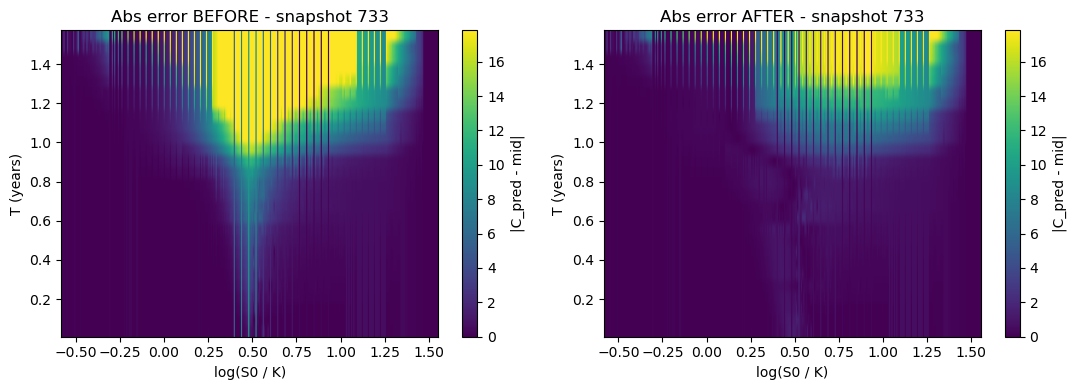

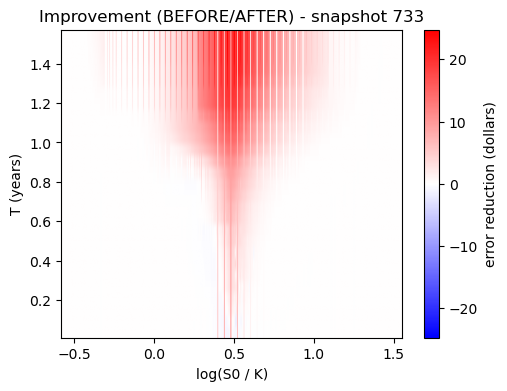

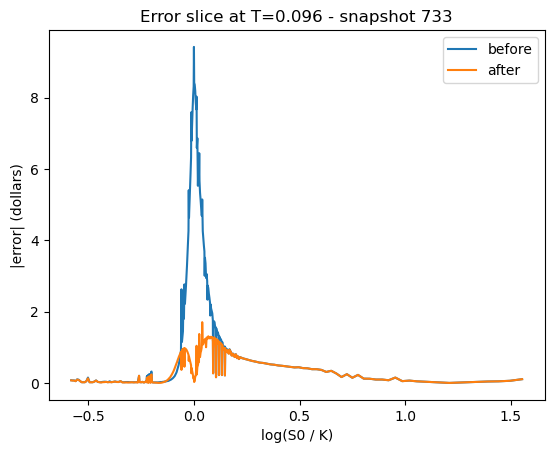

In [44]:
# ---- Make the improvement visible: error heatmaps & slices ----
@torch.no_grad()
def _error_grid(df_s, model, stats, device):
    # predictions
    batch = pack_batch_from_df(df_s, stats, device)
    sigma = model(batch["features"])
    C_hat = bs_call_price(batch["S0"], batch["K"], batch["T"], batch["r"], batch["q"], sigma).cpu().numpy()
    # absolute errors vs mid
    err = np.abs(C_hat - df_s["price_mid"].to_numpy())
    # log-moneyness for the grid
    df_loc = df_s.copy()
    df_loc["log_mny"] = np.log(df_loc["S0"]/df_loc["K"])
    df_loc["err"] = err
    piv = df_loc.pivot_table(index="T", columns="log_mny", values="err", aggfunc="mean")
    piv = piv.sort_index(axis=0).sort_index(axis=1)
    piv = piv.interpolate(axis=0, limit_direction="both").interpolate(axis=1, limit_direction="both")
    return piv.index.values, piv.columns.values, piv.values

# choose the same snapshot you used above (or pick the one with biggest improvement)
sid_plot = 733
df_s = df[df["snapshot_id"]==sid_plot].copy()

T_b, E_b, G_b = _error_grid(df_s, model_before, stats_before, device)   # before errors
T_a, E_a, G_a = _error_grid(df_s, model_after, stats_after,  device)   # after errors

# shared vmax so colors are comparable
vmax = np.percentile(np.r_[G_b.ravel(), G_a.ravel()], 95)  # robust cap

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.imshow(G_b, origin="lower", aspect="auto",
           extent=[E_b.min(), E_b.max(), T_b.min(), T_b.max()],
           vmin=0, vmax=vmax, cmap="viridis")
plt.title(f"Abs error BEFORE - snapshot {sid_plot}")
plt.xlabel("log(S0 / K)"); plt.ylabel("T (years)"); plt.colorbar(label="|C_pred - mid|")

plt.subplot(1,2,2)
plt.imshow(G_a, origin="lower", aspect="auto",
           extent=[E_a.min(), E_a.max(), T_a.min(), T_a.max()],
           vmin=0, vmax=vmax, cmap="viridis")
plt.title(f"Abs error AFTER - snapshot {sid_plot}")
plt.xlabel("log(S0 / K)"); plt.ylabel("T (years)"); plt.colorbar(label="|C_pred - mid|")
plt.tight_layout(); plt.show()

# improvement map (positive = after is better)
plt.figure(figsize=(5.5,4))
delta = G_b - G_a
v = np.max(np.abs(delta))
plt.imshow(delta, origin="lower", aspect="auto",
           extent=[E_b.min(), E_b.max(), T_b.min(), T_b.max()],
           vmin=-v, vmax=v, cmap="bwr")
plt.title(f"Improvement (BEFORE/AFTER) - snapshot {sid_plot}")
plt.xlabel("log(S0 / K)"); plt.ylabel("T (years)")
plt.colorbar(label="error reduction (dollars)")
plt.show()

# one clean slice at a mid tenor
row = np.argmin(np.abs(T_b - np.median(T_b)))
plt.figure()
plt.plot(E_b, G_b[row], label="before")
plt.plot(E_a, G_a[row], label="after")
plt.xlabel("log(S0 / K)"); plt.ylabel("|error| (dollars)")
plt.title(f"Error slice at T={T_b[row]:.3f} - snapshot {sid_plot}")
plt.legend(); 
plt.savefig("my_plot2.pdf", bbox_inches='tight')
plt.show()


Conclusion

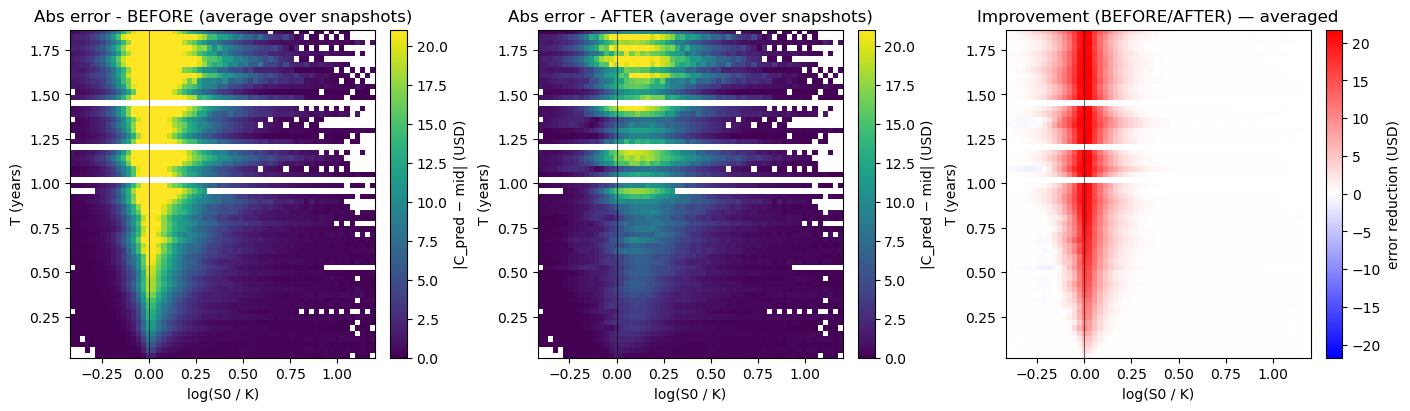

In [47]:
# === Aggregated diagnostic across many snapshots (average heatmaps) ===
# 1) Choose which snapshots to aggregate (e.g., your test_ids or any list/array)
snapshots = test_ids  # or: sorted(df["snapshot_id"].unique())[:100]

# 2) Define ONE global grid over log-moneyness and T
logmny_all = np.log(df["S0"] / df["K"]).to_numpy()
T_all = df["T"].to_numpy()

# trim extremes a bit so the color scale isn’t dominated by outliers
E_min, E_max = np.quantile(logmny_all[np.isfinite(logmny_all)], [0.01, 0.99])
T_min, T_max = np.quantile(T_all[np.isfinite(T_all)],           [0.01, 0.99])

# number of bins in each dimension (tweak to taste)
nE, nT = 60, 60
E_edges = np.linspace(E_min, E_max, nE+1)
T_edges = np.linspace(T_min, T_max, nT+1)
E_cent  = 0.5 * (E_edges[:-1] + E_edges[1:])
T_cent  = 0.5 * (T_edges[:-1] + T_edges[1:])

@torch.no_grad()
def binned_abs_error(df_s, model, stats, device, E_edges, T_edges):
    """Return (sum_err, count) in each 2D bin for a snapshot."""
    if len(df_s) == 0:
        return (np.zeros((len(T_edges)-1, len(E_edges)-1), dtype=np.float64),
                np.zeros((len(T_edges)-1, len(E_edges)-1), dtype=np.float64))

    # predictions (in dollars)
    batch = pack_batch_from_df(df_s, stats, device)
    sigma = model(batch["features"])
    C_hat = bs_call_price(batch["S0"], batch["K"], batch["T"], batch["r"], batch["q"], sigma).cpu().numpy()

    # coords & errors
    log_mny = np.log(df_s["S0"].to_numpy() / df_s["K"].to_numpy())
    Tenor   = df_s["T"].to_numpy()
    err     = np.abs(C_hat - df_s["price_mid"].to_numpy())

    Ei = np.digitize(log_mny, E_edges) - 1
    Ti = np.digitize(Tenor,   T_edges) - 1

    ok = (
        np.isfinite(err) & np.isfinite(Ei) & np.isfinite(Ti) &
        (Ei >= 0) & (Ei < len(E_edges)-1) &
        (Ti >= 0) & (Ti < len(T_edges)-1)
    )

    sum_err = np.zeros((len(T_edges)-1, len(E_edges)-1), dtype=np.float64)
    count = np.zeros_like(sum_err)
    np.add.at(sum_err, (Ti[ok], Ei[ok]), err[ok])
    np.add.at(count,   (Ti[ok], Ei[ok]), 1.0)
    return sum_err, count

# 3) Accumulate across snapshots for BEFORE and AFTER
sum_b = np.zeros((nT, nE), dtype=np.float64); cnt_b = np.zeros_like(sum_b)
sum_a = np.zeros((nT, nE), dtype=np.float64); cnt_a = np.zeros_like(sum_a)

for sid in snapshots:
    df_s = df[df["snapshot_id"] == sid]
    sb, cb = binned_abs_error(df_s, model_before, stats_before, device, E_edges, T_edges)
    sa, ca = binned_abs_error(df_s, model_after,  stats_after,  device, E_edges, T_edges)
    sum_b += sb; cnt_b += cb
    sum_a += sa; cnt_a += ca

# 4) Convert to (weighted) means; mask bins with no data
mean_b = np.divide(sum_b, np.maximum(cnt_b, 1), where=(cnt_b > 0))
mean_a = np.divide(sum_a, np.maximum(cnt_a, 1), where=(cnt_a > 0))
delta  = mean_b - mean_a  # positive = improvement

# after you compute mean_b, mean_a
mean_b[cnt_b == 0] = np.nan
mean_a[cnt_a == 0] = np.nan
delta = mean_b - mean_a

# 5) Plot the aggregated maps with comparable scales
vmax = np.nanpercentile(np.r_[mean_b.ravel(), mean_a.ravel()], 95)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

im0 = axes[0].imshow(mean_b, origin="lower", aspect="auto",
                     extent=[E_cent.min(), E_cent.max(), T_cent.min(), T_cent.max()],
                     vmin=0, vmax=vmax, cmap="viridis")
axes[0].set_title("Abs error - BEFORE (average over snapshots)")
axes[0].set_xlabel("log(S0 / K)"); axes[0].set_ylabel("T (years)")
fig.colorbar(im0, ax=axes[0], label="|C_pred − mid| (USD)")

im1 = axes[1].imshow(mean_a, origin="lower", aspect="auto",
                     extent=[E_cent.min(), E_cent.max(), T_cent.min(), T_cent.max()],
                     vmin=0, vmax=vmax, cmap="viridis")
axes[1].set_title("Abs error - AFTER (average over snapshots)")
axes[1].set_xlabel("log(S0 / K)"); axes[1].set_ylabel("T (years)")
fig.colorbar(im1, ax=axes[1], label="|C_pred − mid| (USD)")

v = np.nanpercentile(np.abs(delta), 99)
im2 = axes[2].imshow(delta, origin="lower", aspect="auto",
                     extent=[E_cent.min(), E_cent.max(), T_cent.min(), T_cent.max()],
                     vmin=-v, vmax=v, cmap="bwr")

axes[2].set_title("Improvement (BEFORE/AFTER) — averaged")
axes[2].set_xlabel("log(S0 / K)"); axes[2].set_ylabel("T (years)")
fig.colorbar(im2, ax=axes[2], label="error reduction (USD)")

# vertical line at ATM
for ax in axes: ax.axvline(0.0, color="k", lw=0.7, alpha=0.6)
plt.savefig("my_plot3.pdf", bbox_inches='tight')
plt.show()


## Conclusion

We presented a small Black–Scholes-in-the-loop network that turns a sparse set of quotes from a
single day into a dense, shape-aware surface. Synthetic pretraining supplies a strong prior, and
per-snapshot adaptation cuts dollar error substantially while retaining basic no-arbitrage structure.
The most important practical lessons were to make the fit loss scale-aware, to schedule the PDE term
after a short warm-up, and to bias collocation toward the regions that matter for evaluation. Future
work includes light American adjustments near ex-dividend dates, integrating put–call parity with
puts in the loss, and testing robustness on other underlyings and market regimes. 

After this class, I aim to improve this model and utilize it in a real-world context, possibly applying it on the current-day market trends. Only time will tell.